In [1]:
import datasets
import pandas as pd
import emoji
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

tweet_tokenizer = TweetTokenizer()
stopwords_set = set(stopwords.words("english"))
emojis = set(emoji.UNICODE_EMOJI["en"].keys())

_The dataset is collected based on the paper __Constructing interval variables via faceted Rasch measurement and multitask deep learning: a hate speech application__ ([link](https://doi.org/10.48550/arxiv.2009.10277))._

_I can be accessed through huggingface:_

In [2]:
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
hate_speech_ucb = dataset['train'].to_pandas()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd
Reusing dataset parquet (/Users/badr/.cache/huggingface/datasets/parquet/ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)
100%|██████████| 1/1 [00:00<00:00, 47.86it/s]


In [3]:
hate_speech_ucb.shape

(135556, 131)

_The paper explains that the dataset was gathered from 50,000 social media comments from `Youtube`, `Twitter` and `Reddit`. The dataset was labeled by 10,000 Mechanical Turk workers._

_The paper talks about the following categories by which the text is classified:_

![image](./column_table.png)

_Our goal is to classify hatespeech, so our objective is to predict the `hatespeech` label:_

In [4]:
hate_speech_ucb["hatespeech"].value_counts()

0.0    80624
2.0    46021
1.0     8911
Name: hatespeech, dtype: int64

_In our dataset, the labels are organized like this:_

- 0 : no
- 1 : unclear
- 2 : yes

In [5]:
HATESPEECH_YES = 2
HATESPEECH_NO = 0
HATESPEECH_UNK = 1

__Hate speech is defined in the paper as:__

_Does this comment contain hate speech, defined as “bias-motivated, hostile and malicious language targeted at a person/group because of their actual or perceived innate characteristics, especially when the group is unnecessarily labeled (e.g., “jew bankers”, “nâĂŞ hooligans”).” The comment contains hate speech if slurs or derogatory language are used toward any person or group regardless of whether or not the target is a member of the slur-target group. (e.g. a comment calling Trump a faggot or a n***** still contains hate speech)._

__A few text examples:__

In [6]:
print(hate_speech_ucb[hate_speech_ucb["hatespeech"] == HATESPEECH_NO]["text"].iloc[:10].to_numpy())

['Yes indeed. She sort of reminds me of the elder lady that played the part in the movie "Titanic" who was telling her story!!! And I wouldn\'t have wanted to cover who I really am!! I would be proud!!!! WE should be proud of our race no matter what it is!!'
 'The trans women reading this tweet right now is beautiful'
 'It is about time for all illegals to go back to their country of origin and keep our freeway open and prevent heavy traffic.'
 "Sounds like the kinda wholsesome life I'd die for ❤️ never met any black Lesbians before so i guess you're my first ever."
 'OMG! The EGO\'s of these young, young, inexperienced women display are remarkable! So self absorbed - so, so proud of the mistakes their constituents all made in giving them a bit of power.  They\'ll be quite surprised to find that the vast majority of Americans think that these women represent the very WORST of "modern" America.  Egos out of control !!'
 '9) uhhhh i like being lgbt a lot. i feel proud of what i have done

In [7]:
print(hate_speech_ucb[hate_speech_ucb["hatespeech"] == HATESPEECH_YES]["text"].iloc[:10].to_numpy())

["Question: These 4 broads who criticize America, what country did they flee to get here? And now they want to make OUR America like THEIR former HELL HOLE. I don't think so!!!!!!!!!!  Let them explain their GRATITUDE for letting them in OUR country."
 "For starters bend over the one in pink and kick that ass and pussy to get a taste until she's begging for a dick inside her."
 'Who the fuck is this insignificant simple minded redneck? When he gets a vagina he can decide what he wants to do with it.'
 'Fuck off you insufferable retarded faggot.'
 'Worthless whore, these tits with look nice with bite marks and cum'
 '@suddenlywestan Because you are a country of mentally ill terrorists. Whoever says different is an enabler, ignorant and blind to endless/countless wars and aggression and the death rate by American terrorist acts. Fuck you American scum!'
 'This sub is full of grade A faggots  Comedy fucking Ebola'
 'Get rid of them and their anchor babies and grand babies. Fucking worthle

In [8]:
print(hate_speech_ucb[hate_speech_ucb["hatespeech"] == HATESPEECH_UNK]["text"].iloc[:10].to_numpy())

['@ghostofthor same energy as the "YOU DONT LOOK INDIAN STOP LYING ABOUT BEING SOUTH ASIAN" cc'
 "Y'all always slip up and say how y'all see women period because this includes the majority of women in yall lives that's not related to you. Especially since men demand pussy just from taking you out, selling you weed or even being nice to you. Niggas can't even be friends lol URL"
 "They wanna fuck so bad, just do it already, nobody cares if you're gay."
 "Fuck Yeah ! Filthy Fuck'n Dirty Cock Cleanin' Sweat Fuck'n Drippin' Total Fuck'n Bottom Slut Christian Gettin' Gang Fuck'n Bred Hard and Fuck'n Rough for Balls Deep Fuck'n Loads of Filthy Fuck'n Dirty Cum Floodin' His Greedy Slutted Out Fuck'n Cunt (T.I.M)(Final Part) 👍 URL"
 "Are you people actually believing this propaganda.....  These ratchet women haven't done a thing , except spew hate and rhetoric....they are gonna get Saddamed..."
 'Bitches be salty as hell when a nigga treat they Ma dukes like a queen but not them 🤣'
 '@Cochis3 

_It's possible to see that the text in this data is very vulgar for all categories, that's why the definition of hatespeech in the paper is important, not all vulgar speech is hatespeech, and the goal of this dataset is to train a model that can make the distinction between the two._

__A few statistics:__

In [9]:
num_emojis = 0
word_counter = Counter()
for sentence in dataset["train"]:
    tokens = tweet_tokenizer.tokenize(sentence["text"])
    if any([token in emojis for token in tokens]):
        num_emojis += 1
    word_counter.update([token.lower() for token in tokens if token.lower() not in stopwords_set and token.isalpha()])

In [10]:
print(f"Average number of emojis per text : {num_emojis / hate_speech_ucb.shape[0]}")

Average number of emojis per text : 0.06553011301602289


In [11]:
word_counter.most_common(50)

[('people', 22322),
 ('url', 19632),
 ('women', 16276),
 ('like', 15936),
 ('fuck', 14531),
 ('fucking', 14174),
 ('get', 13366),
 ('white', 13036),
 ('black', 10431),
 ('go', 9979),
 ('hate', 9551),
 ('men', 9235),
 ('bitch', 8600),
 ('one', 8133),
 ('back', 7913),
 ('even', 7877),
 ('need', 7202),
 ('niggers', 7134),
 ('country', 6885),
 ('know', 6824),
 ('would', 6720),
 ('human', 6636),
 ('stupid', 6537),
 ('every', 6509),
 ('u', 6388),
 ('muslims', 6192),
 ('want', 6180),
 ('see', 6150),
 ('right', 6138),
 ('gay', 6009),
 ('look', 5872),
 ('ass', 5789),
 ('world', 5631),
 ('kill', 5621),
 ('muslim', 5572),
 ('shit', 5407),
 ('die', 5199),
 ('think', 5170),
 ('make', 5127),
 ('america', 5103),
 ('us', 5004),
 ('pussy', 4907),
 ('god', 4626),
 ('love', 4562),
 ('nigger', 4443),
 ('many', 4343),
 ('trans', 4300),
 ('stop', 3958),
 ('really', 3895),
 ('racist', 3739)]

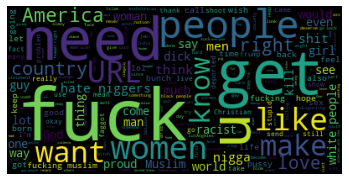

In [13]:
wordcloud = WordCloud(stopwords = stopwords_set).generate(" ".join([sentence["text"] for sentence in dataset["train"]]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

_It's possible to confirm that the language in this dataset is vulgar and that would be a challenge when training because we cannot rely on vocabulary alone to classify._